# **Driver Drowsiness Detection System**

## Import all required packages

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import os
import cv2
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

## Read the data 

In [ ]:
labels_data = os.listdir("/content/drive/MyDrive/train")
labels_data

['yawn', 'Open', 'Closed', 'no_yawn']

## Visualising the data

Yawning image

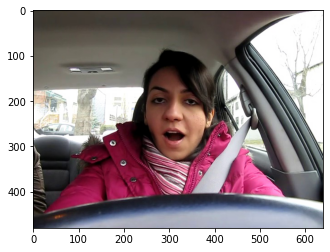

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/train/yawn/11.jpg"))

Not yawning image

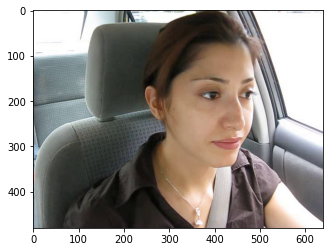

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/train/no_yawn/4.jpg"))

Closed eye image

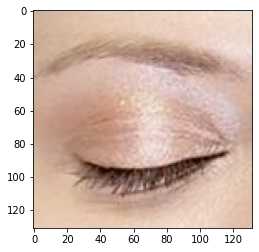

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/train/Closed/_2.jpg"))

Open eye image

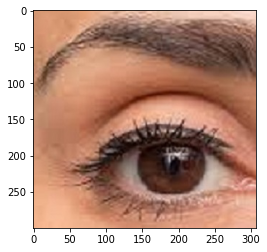

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/train/Open/_6.jpg"))

## Detect faces using Cascade classifier

In [ ]:
def face_yawn(data_path="/content/drive/MyDrive/train", face_cas_path="/content/drive/MyDrive/haarcascade_frontalface_default.xml"):
    yaw_num = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(data_path, category)
        class_num = categories.index(category)
        print(class_num)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_num.append([resized_array, class_num])
    return yaw_num

yawn_or_no_yawn = face_yawn()

0
1


In [ ]:
def face_eyes(data_path="/content/drive/MyDrive/train", eye_cas="/content/drive/MyDrive/haarcascade_eye.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    eyes_num = []
    for label in labels:
        path = os.path.join(data_path, label)
        class_num1 = labels.index(label)
        class_num1 +=2
        print(class_num1)
        for img in os.listdir(path):
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                eyes_cascade = cv2.CascadeClassifier(eye_cas)
                eyes = eyes_cascade.detectMultiScale(img_array, 1.3, 5)
                for (x, y, w, h) in eyes:
                    img = cv2.rectangle(img_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    roi_color = img[y:y+h, x:x+w]
                    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    eyes_num.append([resized_array, class_num1])

    return eyes_num

eyes_close_open = face_eyes()

2
3



## Preparing data

In [ ]:
def append_data():
    yaw_num = face_yawn()
    eyes_num = face_eyes()
    yaw_num.extend(eyes_num)
    return np.array(yaw_num)
total_data=append_data()

0
1
2
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [ ]:
X = []
y = []
for feature, label in total_data:
    X.append(feature)
    y.append(label)

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
y = np.array(y)

## Splitting of data

In [ ]:
from sklearn.model_selection import train_test_split
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=test_size)

NameError: ignored

## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

## CNN Model

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

## Fitting data to the model

In [ ]:
history = model.fit(train_generator, epochs=40, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/40
26/26 [==============================] - 42s 361ms/step - loss: 1.0360 - accuracy: 0.5501 - val_loss: 0.7055 - val_accuracy: 0.7163
Epoch 2/40
26/26 [==============================] - 7s 251ms/step - loss: 0.5741 - accuracy: 0.7286 - val_loss: 0.5797 - val_accuracy: 0.8624
Epoch 3/40
26/26 [==============================] - 7s 248ms/step - loss: 0.4835 - accuracy: 0.7805 - val_loss: 0.4414 - val_accuracy: 0.8624
Epoch 4/40
26/26 [==============================] - 6s 245ms/step - loss: 0.3907 - accuracy: 0.8516 - val_loss: 0.3427 - val_accuracy: 0.9017
Epoch 5/40
26/26 [==============================] - 6s 246ms/step - loss: 0.3386 - accuracy: 0.8782 - val_loss: 0.2778 - val_accuracy: 0.9185
Epoch 6/40
26/26 [==============================] - 7s 254ms/step - loss: 0.3038 - accuracy: 0.8830 - val_loss: 0.2608 - val_accuracy: 0.9157
Epoch 7/40
26/26 [==============================] - 7s 250ms/step - loss: 0.2602 - accuracy: 0.8902 - val_loss: 0.2685 - val_accuracy: 0.9326
Epoch

## Evaluate Model

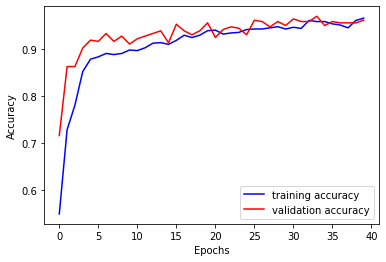

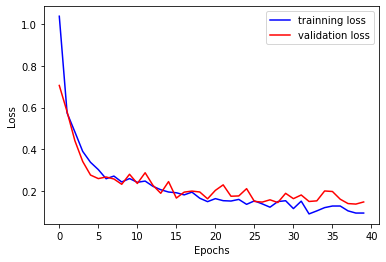

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="training accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
prediction = model.predict(X_test)
classes_x=np.argmax(prediction,axis=1)
classes_x

array([1, 3, 3, 3, 2, 3, 3, 3, 0, 0, 1, 3, 2, 0, 2, 3, 3, 3, 2, 2, 3, 3,
       0, 3, 3, 1, 3, 2, 3, 0, 0, 0, 3, 2, 3, 0, 1, 0, 3, 1, 1, 0, 0, 3,
       3, 3, 0, 0, 2, 0, 2, 0, 0, 1, 3, 2, 0, 0, 3, 2, 3, 2, 1, 1, 2, 3,
       0, 1, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 0, 2, 0, 3, 0, 1,
       0, 3, 0, 3, 0, 3, 1, 0, 3, 1, 2, 0, 0, 3, 1, 0, 2, 3, 0, 2, 3, 3,
       3, 3, 1, 3, 3, 0, 3, 3, 0, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 2, 0, 3,
       1, 0, 1, 1, 3, 2, 3, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 3, 0, 0, 3, 2,
       0, 2, 3, 3, 3, 3, 3, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 1, 3, 3, 0, 3,
       2, 1, 1, 1, 3, 2, 0, 3, 0, 2, 2, 3, 3, 3, 2, 0, 2, 2, 0, 0, 0, 0,
       0, 3, 1, 0, 3, 3, 1, 0, 1, 0, 3, 2, 3, 1, 0, 2, 3, 3, 1, 0, 1, 1,
       3, 1, 3, 0, 1, 2, 2, 3, 2, 0, 3, 3, 3, 3, 0, 3, 3, 2, 0, 0, 3, 3,
       3, 3, 0, 3, 2, 3, 0, 3, 0, 0, 3, 3, 3, 2, 3, 3, 3, 3, 3, 0, 3, 0,
       3, 0, 0, 3, 0, 0, 3, 3, 3, 2, 3, 3, 3, 1, 0, 3, 1, 3, 3, 0, 3, 1,
       2, 2, 3, 3, 3, 3, 0, 3, 2, 2, 0, 1, 3, 3, 3,

Accuracy

In [ ]:
train_accuracy=accuracy[39]
valid_accuracy=val_accuracy[39]

In [ ]:
print("Train accuracy: {}".format(train_accuracy*100))
print("validation accuracy: {}".format(valid_accuracy*100))

Train accuracy: 96.5018093585968
validation accuracy: 96.06741666793823


Confusion matrix

In [ ]:
Y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(multilabel_confusion_matrix(y_test, Y_pred))

Confusion Matrix
[[[255  22]
  [  4  75]]

 [[292   4]
  [ 23  37]]

 [[289  13]
  [  4  50]]

 [[188   5]
  [ 13 150]]]


Classification Report

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred,target_names=labels_new))

Classification Report: 
               precision    recall  f1-score   support

        yawn       0.77      0.95      0.85        79
     no_yawn       0.90      0.62      0.73        60
      Closed       0.79      0.93      0.85        54
        Open       0.97      0.92      0.94       163

    accuracy                           0.88       356
   macro avg       0.86      0.85      0.85       356
weighted avg       0.89      0.88      0.87       356



## Predicting function

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/train/yawn/1.jpg")])
print(np.argmax(prediction))

3


In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/train/no_yawn/1067.jpg")])
np.argmax(prediction)

1

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/train/Closed/_101.jpg")])
f=np.argmax(prediction)
f

2

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/train/Open/_151.jpg")])
np.argmax(prediction)

3

In [ ]:
from IPython.display import Audio
sound_file ='alarm.mp3'
Audio(sound_file, autoplay=True)